# Example of RC for Lorenz 1963 System

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy import stats

sys.path.insert(1, '../')
#import reservoir and system code
from reservoir import *
from system import *

First we define and analyse the system we're trying to predict.  Here we have the lorenz 1963 system.

In [2]:
sigma = 10   # Prandlt number
rho = 28     # Rayleigh number
beta = 8.0/3

D = 3

#lorenz63 model
def lorenz(n, t, p):
    sigma, rho, beta = p
    x, y, z = n
    dxdt = sigma*(y-x)
    dydt = x*(rho-z)-y
    dzdt = x*y - beta*z
    dXdt = [dxdt, dydt, dzdt]
    return dXdt

def jac(X, t, p):
    sigma, rho, beta = p
    x, y, z = X
    return np.array([[-sigma, sigma, 0],
                     [-z+rho, -1, -x],
                     [y, x, -beta]])

# build the system from the dynamical equations
# jacobian is not necessary if you do not care about the lyapunov exp
lor63sys = system(lorenz, (sigma, rho, beta), D, 0.001, fjac = jac)

Now we integrate the system to define the function that we feed to the reservoir.  Make sure that the system is defined for negative times in order to synchronize the reservoir and is defined far enough in the future to enable comparison to the prediction.

In [3]:
%%time
t, u = lor63sys.integrate(-100, 200)

CPU times: user 501 ms, sys: 25.4 ms, total: 526 ms
Wall time: 679 ms


## System analysis

Next we do some analysis of the system.

1) Find the embedding dimension for the input system

2) Find the lyapunov exponents for the system

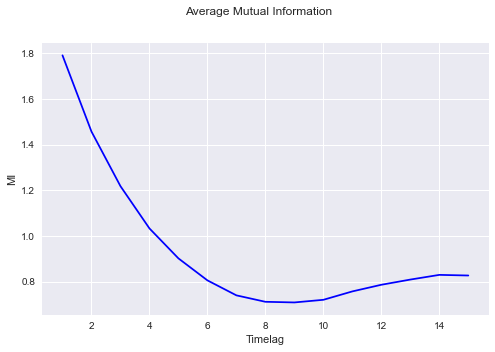

Enter a number up to search for first minimum
end search: 12
The first min of MI is: T=9


9

In [4]:
# Here we find the optimal time delay by getting the first minumum of
# the average mutual information of the time delayed system.
lor63sys.findMinAMI(0.3, sample = 20)

To find the embedding dimension for the data we run the false nearest neighbors algorithm

In [5]:
%%time
lor63sys.FNN(6)

[99.4  6.   0.1  0.   0.   0. ]
minimum embedding dimension is 3 with NFNN 0.094
CPU times: user 1.17 s, sys: 22.6 ms, total: 1.2 s
Wall time: 1.28 s


### Lyapunov Exponents

We can get the global lyapunov exponents of the system using the globalLyap function.  For differentiable systems such as the ones defined here one of the exponents should trend to 0. If it does not then you should run the algorithm for a longer time

In [6]:
%%time
#standard values: [0.9056 0 −14.5721]
LE = lor63sys.globalLyap(90, 0.01)
print(np.round(LE, 3))

[  0.923   0.042 -14.668]
CPU times: user 2.8 s, sys: 38 ms, total: 2.83 s
Wall time: 3.01 s


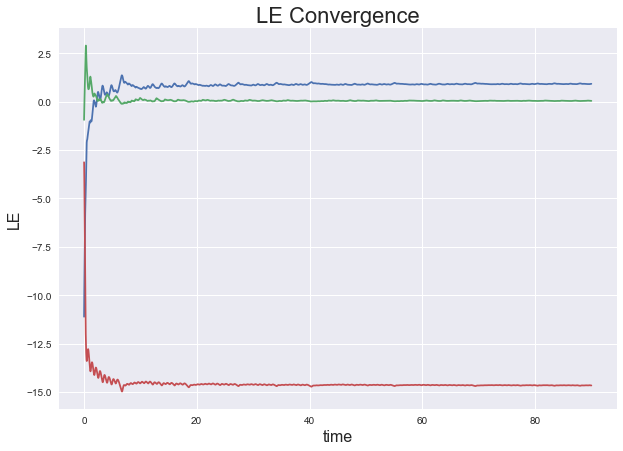

In [7]:
fig = plt.figure(figsize = (10, 7))
plt.plot(lor63sys.LE_t, lor63sys.LE);
plt.xlabel('time', fontsize = 16)
plt.ylabel('LE', fontsize = 16)
plt.title('LE Convergence', fontsize = 22);
fig.savefig('LE_convergence.pdf', bbox_inches = 'tight')

The Kaplan-Yorke (KY) dimension gives the fractal dimension of the attractor

In [8]:
lor63sys.getKYDim()

2.0657935378637537

## Finite Time Lyapunov Exponents

The FTLE is a measure of the stability of a particular region of phase space.  It is computed at a point $x_0$ and over a finite time $T$, giving the stability of that point over a short trajectory.

CPU times: user 90.1 ms, sys: 33.2 ms, total: 123 ms
Wall time: 21.5 s


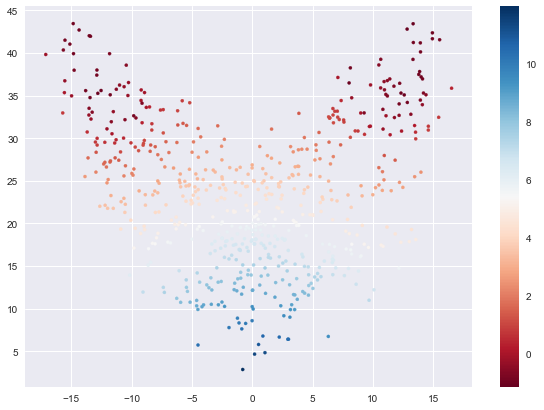

In [9]:
%%time
L = 2
dt = 0.05
skip = 500
scat = u[np.random.choice(u.shape[0], u.shape[0]//skip, replace = False)]
LE = lor63sys.localExp(scat, L, dt, multi = True)
fig = plt.figure(figsize = (10, 7))
plt.scatter(scat[:, 0], scat[:, 2], s = 10, c = LE[:, 0], cmap = 'RdBu')
plt.colorbar()

## Reservoir

Now we define the parameters for our reservoir.  The performance of the reservoir is very dependent on the parameters and the parameters depend on the system.

Make sure D (dimension) is the same as for the input system

In [20]:
N = 2000
sigma = 0.014 #scaling of the input

# dr/dt = gamma * (-r + tanh(M*r+Win*u))
params = {'name': 'Lor63',
          'N': N, #number of neurons
          'D': D, #dimension of the input system
          'gamma': 10, #time constant for the system
          'M_a': -1, #M connectivity matrix lower bound
          'M_b': 1, #M connectivity matrix upper bound
          'M_pnz': 0.02, #M connectivity matrix sparsity
          'M_SR': 0.9, #M connectivity matrix spectral radius
          'Win_a': -sigma, #Win input matrix lower bound
          'Win_b': sigma, #Win input matrix upper bound
          'time_step': 0.001, #integration time step for reservoir
          'spinup_time': 5, #time it takes to synchronize res with sys
          'system': lor63sys, #system to run reservoir over
          'saveplots': False} #save the plots


#build the reservoir
lor63Res = reservoir(params)

## Training

To train the reservoir we need to

1) define function Q s.t. Wout Q(r) = u

2) define constraints on Wout if needed

In [21]:
%%time
def Q(r): return np.hstack((r, np.power(r, 2)))

train_time = 60 #time for training

#time between training points (must be a multiple of the res time step)
train_time_step = 0.02

#regularization term
beta = 1e-6

#optional parameter, must be integers
constraints = [[(0, N)],
               [(0, N)],
               [(0, N//2), (3*N//2, 2*N)]]

data = lor63Res.train(train_time, #time to train the reservoir
                      train_time_step, #time step over which to train (> integration time step)
                      Q,
                      beta,
                      constraints = constraints)

CPU times: user 17.5 s, sys: 935 ms, total: 18.5 s
Wall time: 11.4 s


In [22]:
lor63Res.cost

1.0763368209364973e-06

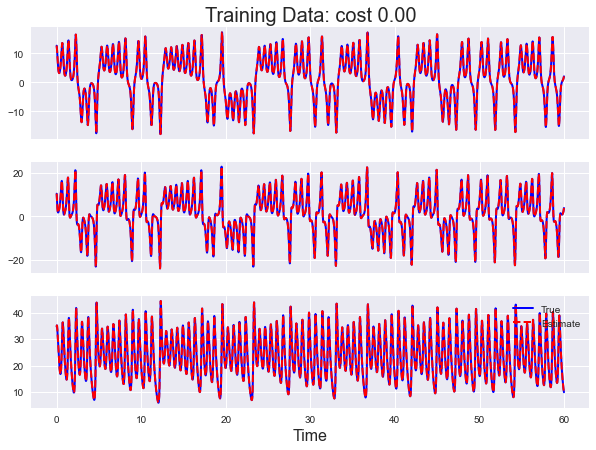

In [23]:
lor63Res.plotTraining()

## Spinup/Synchronization Period

Before predicting we "spin up" the reservoir to make sure that it is synchronized to the data

In [24]:
spinup = lor63Res.getSpinup()
_, U, spin = spinup(1)
t = np.arange(-lor63Res.trans_time, 0, lor63Res.time_step)

In [25]:
spinD = np.dot(lor63Res.Wout, Q(spin).T)

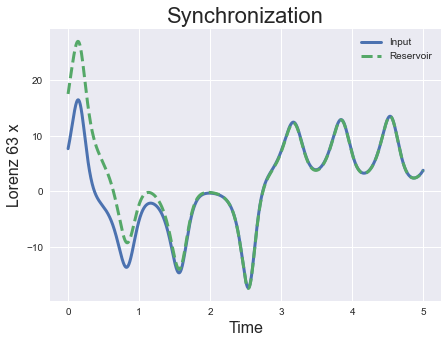

In [26]:
fig = plt.figure(figsize = (7, 5))
end = -1
plt.plot(t[:end]+lor63Res.trans_time, U(t)[0][:end], lw = 3, label = 'Input')
plt.plot(t[:end]+lor63Res.trans_time, spinD[0][:end], lw = 3, ls = '--', label = 'Reservoir')
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Lorenz 63 x', fontsize = 16)
plt.title('Synchronization', fontsize = 22)
plt.legend()
# fig.savefig('results/Synchronization.pdf', bbox_inches = 'tight')

### Prediction step

Here we predict forward in time using the Wout given by the training data.  The first time point is at the end of a period of time where we synchronize the system and the reservoir. The prediction follows the true trajectory closely until it eventually diverges due to the chaotic nature of the Lorenz attractor.  The vertical line gives a numerical estimate of where the trajectories start to diverge.

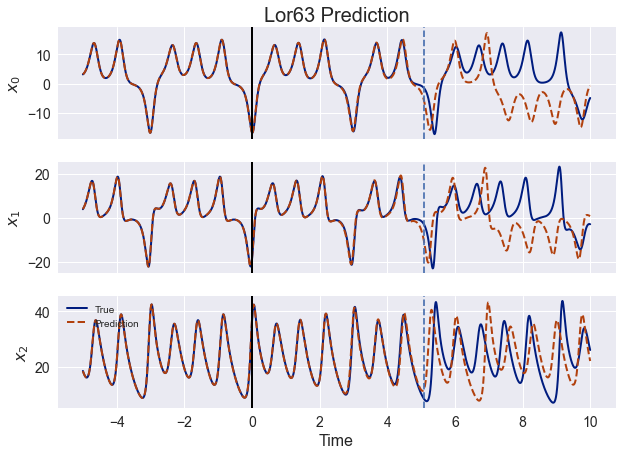

CPU times: user 9.52 s, sys: 556 ms, total: 10.1 s
Wall time: 5 s


In [18]:
%%time
lor63Res.time_step = 0.001
lor63Res.ifsave = True
acc = 1
pred, u_pred, u_true = lor63Res.predict(10, acc = acc, show = True, retDat = True)
lor63Res.ifsave = False

In [14]:
print(np.linalg.norm(np.mean(u_pred, axis = 1)-np.mean(u_true, axis = 1)))
print(np.linalg.norm(np.std(u_pred, axis = 1)-np.std(u_true, axis = 1)))

5.204305283742406
0.6176506468509231


Text(0.5, 1.0, 'Testing Prediction')

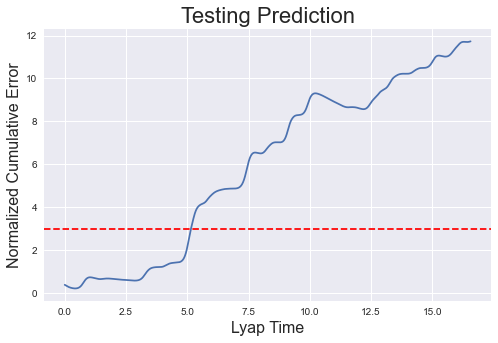

In [15]:
plt.style.use('seaborn')
fig = plt.figure(figsize = (8, 5))
plt.plot(lor63Res.pred_t/0.9056, np.cumsum(lor63Res.diff)/np.arange(1, len(lor63Res.diff)+1))
plt.axhline(acc, ls = '--', c = 'r')
plt.xlabel('Lyap Time', fontsize = 16)
plt.ylabel('Normalized Cumulative Error', fontsize = 16)
plt.title('Testing Prediction', fontsize = 22)
# fig.savefig('cum_error.pdf', bbox_inches = 'tight')

## Prediction variation

In [24]:
%%time
lyap = 0.9056
n = 1000
pred = np.zeros(n)
x = np.zeros((n,lor63sys.D))
for i in range(n):
    pred[i] = lor63Res.predict(15, acc = 1, show = False)
    x[i] = lor63Res.predSysx0
pred = pred*lyap
np.savez('results/pred_var.npz', x = x, pred = pred)

In [27]:
pred = np.load('results/pred_var.npz')['pred']
x = np.load('results/pred_var.npz')['x']

In [36]:
L = 64
dt = 0.05
T = L*dt
LE = lor63sys.localExp(x, L, dt, multi = True)

Text(0.5, 1.0, 'Prediction Location')

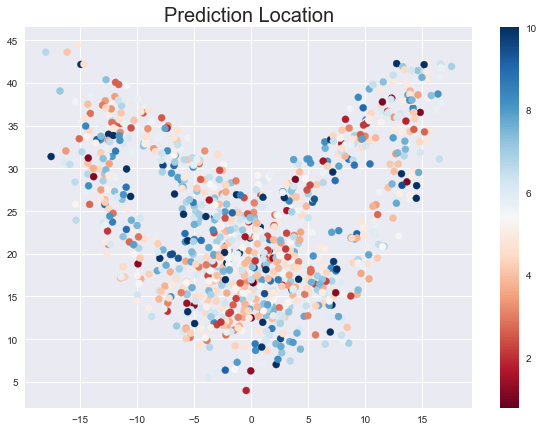

In [28]:
colors = np.copy(pred)
colors[colors > 10] = 10
fig = plt.figure(figsize = (10, 7))
plt.scatter(x[:, 0], x[:, 2], s = 50, c = colors, cmap = 'RdBu')
plt.colorbar()
plt.title('Prediction Location', fontsize = 20)
# fig.savefig('prediction.pdf', bbox_inches = 'tight')

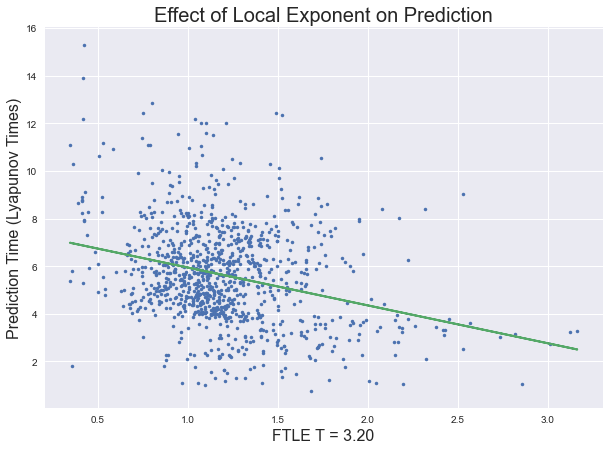

In [45]:
plt.style.use('seaborn')
fig = plt.figure(figsize = (10, 7))
xle = LE[:, 0]
yle = pred


plt.plot(xle, yle, '.')
m, b = np.polyfit(xle, yle, 1)
plt.plot(xle, m*xle+b, lw = 2)
plt.xlabel('FTLE T = {:1.2f}'.format(T), fontsize = 16)
plt.ylabel('Prediction Time (Lyapunov Times)', fontsize = 16)
plt.title('Effect of Local Exponent on Prediction', fontsize = 20)
fig.savefig('results/FTLE_prediction.pdf', bbox_inches = 'tight')

In [14]:
for l in L:
    T = l*dt
    LE = lor63sys.localExp(x, l, dt, multi = False)
    fig = plt.figure(figsize = (7, 5))
    plt.plot(diff*np.exp(LE[:, 0]*T), pred, 'o')
    plt.xscale('log')
    plt.xlabel('diff exp(lambda t)', fontsize = 16)
    plt.ylabel('Prediction Time (Lyapunov Times)', fontsize = 16)
    plt.title('Effect of Local Exponent on Prediction', fontsize = 20)
#     fig.savefig('FTLE_prediction_T{:1.2f}.pdf'.format(T), bbox_inches = 'tight')

The mean prediction time is 5.63 with std 2.10


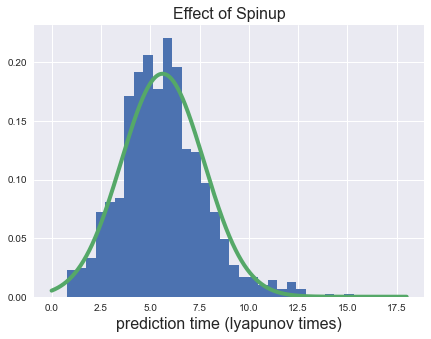

In [29]:
fig = plt.figure(figsize = (7, 5))
plt.hist(pred, density = True, bins = 30)
plt.title('Effect of Spinup', fontsize = 16)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(pred))

# lets try the normal distribution
m, s = stats.norm.fit(pred) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm", lw = 4) # plot it
plt.xlabel('prediction time (lyapunov times)', fontsize = 16)
print('The mean prediction time is {:1.2f} with std {:1.2f}'.format(m, s))
fig.savefig('results/spinup_variation.pdf', bbox_inches = 'tight')

In [26]:
np.max(pred)

15.304770318021202